I am working with an imbalanced dataset of credit card transactions (authentic and fraudulent) from Kaggle.

Link to the dataset: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud.

In [1]:
# Standard Libraries
import time
import psutil
import os
import gc
import math

# Data Manipulation and Visualization Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Additional Libraries
from tqdm.contrib import itertools

pal_ = list(sns.color_palette(palette='inferno_r',
                              n_colors=5).as_hex())
BinCol = [pal_[0], pal_[4]]


In [2]:
# Importing data
data = pd.read_csv('creditcard.csv')

# Exploratory data analysis

In [166]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

The columns in the dataset are as follows:

**Time**: The time (in seconds) elapsed between the transaction and the very first transaction

**V1 to V28**: Obtained from principle component analysis (PCA) transformation on original features that are not available due to confidentiality

**Amount**: The amount of the transaction

**Class**: The status of the transaction concerning authenticity. The class of an authentic (resp. fraudulent) transaction is taken to be 0 (resp. 1).


In [167]:
data.describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

       ...           V21           V22           V23           V24  \
count  ...  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   ...  1.654067e-16 -3.568593e-16  2.578648e-16  4.473266e-15   
std    ...  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min    ... -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%    ... -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%    ... -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    ...  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    ...  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                V25           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   5.340915e-16  1.683437e-15 -3.660091e-16 -1.227390e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000   
50%    1.659350e-02 -5.213911e-02  1.342146e-03  1.124383e-02      22.000000   
75%    3.507156e-01  2.409522e-01  9.104512e-02  7.827995e-02      77.165000   
max    7.519589e+00  3.517346e+00  3.161220e+01  3.384781e+01   25691.160000   

               Class  
count  284807.000000  
mean        0.001727  
std         0.041527  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 31 columns]

In [3]:
if data.isnull().sum().all() == 0:
    print("There are no missing values in the dataset.")
else: 
    print("There are missing values.")

There are no missing values in the dataset.


There are two features: **time** and **amount** that stand out, due to a much larger range of values. Let's take a closer look at them. 

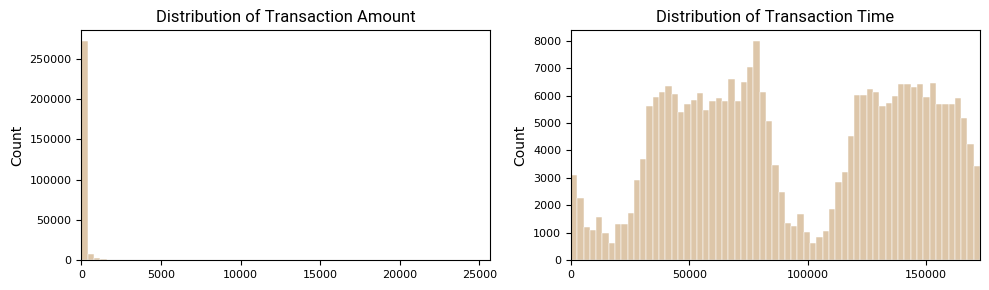

In [4]:
# Define the number of bins using the cube root rule
bins = math.floor(len(data) ** (1/3))

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# Plot histogram for 'Amount'
sns.histplot(data['Amount'].values, ax=ax[0], bins=bins, color='tan', edgecolor='white')
ax[0].set_title('Distribution of Transaction Amount', fontname='Roboto', fontsize=12)
ax[0].set_xlim(data['Amount'].min(), data['Amount'].max())
ax[0].tick_params(axis='both', which='major', labelsize=8)

# Plot histogram for 'Time'
sns.histplot(data['Time'].values, ax=ax[1], bins=bins, color='tan', edgecolor='white')
ax[1].set_title('Distribution of Transaction Time', fontname='Roboto', fontsize=12)
ax[1].set_xlim(data['Time'].min(), data['Time'].max())
ax[1].locator_params(axis='x', nbins=6)
ax[1].tick_params(axis='both', which='major', labelsize=8)

# Display the plots
plt.tight_layout()
plt.show()

The "amount" feature exhibits significant skewness, with a predominance of smaller monetary values. To address this skewness and facilitate visualization across the entire range of values, I apply a logarithmic transformation to the feature. Additionally, I include a small positive constant, such as 0.001, to account for zero-amount transactions. This ensures the prevention of undefined quantities resulting from the logarithm of zero (log(0)).






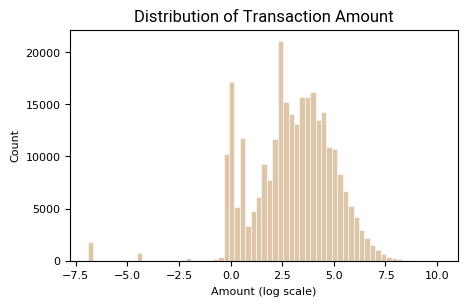

In [5]:
# Compute log-transformed values for 'Amount'
amountlog_count = np.log(data['Amount'] + 0.001)

# Create the histogram plot
plt.figure(figsize=[5,3])
sns.histplot(amountlog_count, bins=bins, color='tan', edgecolor='white')

# Set title and axis labels
plt.title('Distribution of Transaction Amount', fontname='Roboto', fontsize=12)
plt.xlabel('Amount (log scale)', fontsize=8)
plt.ylabel('Count', fontsize=8)

# Set font sizes for ticks
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Display the plot
plt.show()

Finally, let's check the imbalance of the dataset.

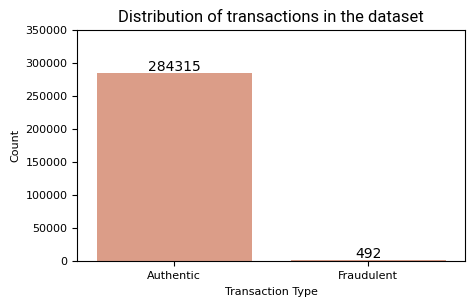

In [6]:
# Count the number of authentic and fraudulent transactions
auth = (data['Class'] == 0).sum()
fraud = (data['Class'] == 1).sum()

# Create a DataFrame for the distribution
dist = pd.DataFrame({'Transaction Type': ['Authentic', 'Fraudulent'],
                     'Count': [auth, fraud]})

# Create the bar plot
plt.figure(figsize=[5, 3])
sns.barplot(data=dist, color='darksalmon', x='Transaction Type', y='Count')

# Set title and axis labels
plt.title('Distribution of transactions in the dataset', fontname='Roboto', fontsize=12)
plt.xlabel('Transaction Type', fontsize=8)
plt.ylabel('Count', fontsize=8)

# Set font sizes for ticks
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Set y-axis limit
plt.ylim(0, 350000)

# Display counts on top of bars
for i, count in enumerate(dist['Count']):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()

# Objective 

The main objective with this dataset is anomaly detection, with a focus on developing a model capable of rapidly identifying fraudulent transactions in real-time. Speed is crucial, although the primary aim is to accurately flag fraudulent transactions.

Initially, I employ a probabilistic anomaly detection technique, specifically using a multivariate Gaussian (or normal) distribution. This method operates on the assumption that authentic transactions follow a multivariate normal distribution within the feature space, and deviations from this distribution are flagged as anomalies. Thus, when presented with a new transaction, if the density value of the fitted distribution falls below a pre-specified threshold, the transaction is marked as potentially fraudulent. Data pre-processing involves feature selection via correlation matrix and visual comparison of distributions.

Subsequently, I compare this method with various anomaly detection algorithms, including logistic regression, random forest, Support Vector Machine (SVM), and k-nearest neighbors classifier, as well as a combination of the k-nearest neighbors classifier, linear discriminant analysis, and linear regression, based on a method outlined in a research paper. To address the imbalanced dataset, I employ resampling techniques, specifically oversampling using the Synthetic Minority Over-sampling Technique (SMOTE) to synthesize new instances from existing data using the k-nearest neighbor method. Additionally, for faster and more accurate model training, features are selected based on their importance, as measured by a random forest classifier.

In comparing the models, I prioritize metrics such as recall, F1-score, and F2-score, with precision considered to a lesser extent, aiming to maximize the identification of fraudulent transactions.

# Evaluation metrics

Explanation of Metrics:

**True Positive (TP)**: Correctly predicted positive instances - correctly classified fraud transactions.

**True Negative (TN)**: Correctly predicted negative instances - 

**False Positive (FP)**: Incorrectly predicted positive instances.

**False Negative (FN)**: Incorrectly predicted negative instances.

**Precision**: Proportion of correctly identified positive cases among all predicted positive cases.

**Recall**: Proportion of correctly identified positive cases among all actual positive cases.

**Accuracy**: Proportion of correctly classified instances among the total instances.

**F1-Score**: Harmonic mean of precision and recall, giving a balance between the two.

**F2-Score**: F-beta score with beta = 2, placing more emphasis on recall than precision.

**Confusion Matrix**: Matrix showing the counts of true positives, true negatives, false positives, and false negatives.

As the dataset is highly imbalanced, thus I will not be considering the model's accuracy, instead deducing metrics such as **recall, precision** and **F-measure**.  

In [7]:
from sklearn.metrics import confusion_matrix


def conf_mat(y_true, y_pred):

    y_true, y_pred = list(y_true), list(y_pred)
    confusion_mat = confusion_matrix(y_true, y_pred)

    return confusion_mat

def show_conf_mat(y_true, y_pred):

    confusion_mat = conf_mat(y_true, y_pred) 

    plt.figure(figsize= [5,3])
    sns.heatmap(confusion_mat,
            annot=True,
            fmt='d',
            xticklabels=['Authenthic','Fraudulent'],
            yticklabels=['Authenthic','Fraudulent'],
            cbar = False,
            cmap = [pal_[4], pal_[0]])

    plt.ylabel('Actual',fontsize=10)
    plt.xlabel('Prediction',fontsize=10)
    plt.xticks(fontsize=8, fontname = 'Roboto')
    plt.yticks(fontsize=8, fontname = 'Roboto')
    plt.show()

def metrics(y_true, y_pred):
    
    confusion_mat = conf_mat(y_true, y_pred)
    tn, fp, fn, tp = confusion_mat[0, 0], confusion_mat[0, 1], confusion_mat[1, 0], confusion_mat[1, 1]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)    
    f1 = (2 * tp) / ((2 * tp) +  fn + fp)
    f2 = (5 * tp) / ((5 * tp) + (4 * fn) + fp)

    return precision, recall, f1, f2
    

# Feature engineering

Amount and time of the transaction are two features that have widely different values than the rest. To make sure the data is on the same scale and improve the models' performance, I rescale these two.

In [8]:
from sklearn.preprocessing import RobustScaler

data['amount_log'] = np.log(data['Amount'] + 0.001)

rob_scaler = RobustScaler()

data['scaled_amount_log'] = rob_scaler.fit_transform(data['amount_log'].values.reshape(-1,1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))
data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V24       V25       V26       V27       V28  \
0  0.098698  0.363787  ...  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1  0.085102 -0.255425  ... -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.247676 -1.514654  ... -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.377436 -1.387024  ... -1.175575  0.647376 -0.221929  0.062723  0.061458   
4 -0.270533  0.817739  ...  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  amount_log  scaled_amount_log  scaled_time  
0  149.62      0    5.008105           0.730845    -0.994983  
1    2.69      0    0.989913          -0.801054    -0.994983  
2  378.66      0    5.936641           1.084841    -0.994972  
3  123.50      0    4.816249           0.657702    -0.994972  
4   69.99      0    4.248367           0.441202    -0.994960  

[5 rows x 34 columns]

In [9]:
data = data.drop(['Time', 'Amount', 'amount_log'], axis=1)

# Multivariate Gaussian distribution method

## Dataset split

I am splitting the data into training set, validation set and test set in 70-15-15 ratio. In this model, the fraudulent data is split only between the validation and test set, as the training set includes only the authenthic data to train the model to look for anomalies.

In [10]:
data_A, data_F = data[data.Class == 0], data[data.Class == 1]

# Feature-target split

x_A, y_A = data_A.drop(columns=['Class']), data_A['Class']
x_F, y_F = data_F.drop(columns=['Class']), data_F['Class']

# Splitting the data into the training set, validation set, and test set

x_A_train, x, y_A_train, y = train_test_split(x_A, y_A, test_size = 0.30, random_state = 42) 
x_A_val, x_A_test, y_A_val, y_A_test = train_test_split(x, y, test_size = 0.50, random_state = 42)
data_train, data_val_A, data_test_A = pd.concat([x_A_train, y_A_train], axis = 1), pd.concat([x_A_val, y_A_val], axis = 1), pd.concat([x_A_test, y_A_test], axis = 1)

# Splitting the fraudulent data into validation and test sets

x_F_val, x_F_test, y_F_val, y_F_test = train_test_split(x_F, y_F, test_size = 0.50, random_state = 42) 
data_val_F, data_test_F = pd.concat([x_F_val, y_F_val], axis = 1), pd.concat([x_F_test, y_F_test], axis = 1)

# Merging authentic and fraudulent data for the validation set and the test set

data_val, data_test = pd.concat([data_val_A, data_val_F], axis = 0), pd.concat([data_test_A, data_test_F], axis = 0)
x_val, y_val = data_val.drop(columns = ['Class']), data_val['Class']
x_test, y_test = data_test.drop(columns = ['Class']), data_test['Class']
x_train = data_train.drop(columns = ['Class'])

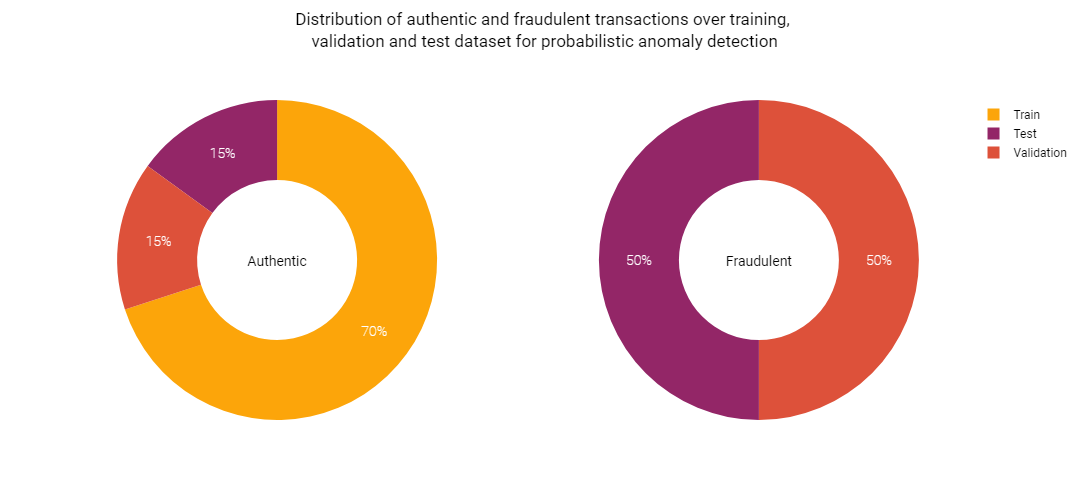

In [10]:
# Visualisation of the split 

from textwrap import wrap


labels = ['Train', 'Validation', 'Test']
ratios = [len(x_A_train)/len(x_A), len(x_A_val)/len(x_A), len(x_A_test)/len(x_A)]
ratios0 = [0, len(x_F_val)/len(x_F), len(x_F_test)/len(x_F)]


pal_ = list(sns.color_palette(palette='inferno_r',
                              n_colors=4).as_hex())

fig = make_subplots(rows = 1, cols = 2, specs = [[{'type': 'domain'}, {'type': 'domain'}]])

fig.add_trace(go.Pie(values = ratios, labels = labels, hole = 0.5, textinfo = 'percent', title = "Authentic", title_font=dict(size=14),
                     marker=dict(colors=pal_)),
              row = 1, col = 1)
fig.add_trace(go.Pie(values = ratios0, labels = labels, hole = 0.5, textinfo = 'percent', title = "Fraudulent", title_font=dict(size=14)),
              row = 1, col = 2)
fig.update_traces(textfont=dict(family="Roboto Thin", size=14, color= 'white'), selector=dict(type='pie'))

text_title = "Distribution of authentic and fraudulent transactions over training,<br> validation and test dataset for probabilistic anomaly detection"

fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95),  
                  font=dict(family="Roboto", size=12, color="black")) 
fig.show()




## Feature selection 

In the dataset, there are 30 features following PCA treatment. Firstly, I'll check if any of them strongly correlate with each other, or if they can be treated as independent. For that, I'm using a correlation matrix as a heatmap. Furthermore, to determine the significant features, I'll analyse the distribution of each feature across authentic and fraudulent transactions. If the distributions appear similar, the feature is unlikely to be significant. I'll visualise this comparison using distribution visualisation and boxplots.

Additionally, I will plot another correlation matrix with respect to the class (authentic or fraudulent) to verify the significance. To prevent data leakage, I am not using the whole dataset. As the training set includes only authentic transactions, I am using the validation set for this purpose.

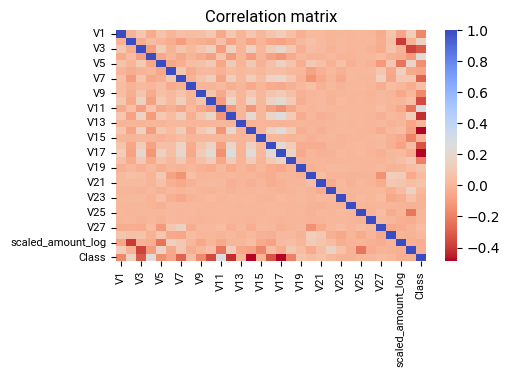

In [11]:
plt.figure(figsize=[5,3])
sns.heatmap(data_val.corr(), cmap= 'coolwarm_r', cbar = True)
plt.title('Correlation matrix', fontname='Roboto', fontsize=12)
plt.xticks(fontsize=8, fontname = 'Roboto')
plt.yticks(fontsize=8, fontname = 'Roboto')
plt.show()

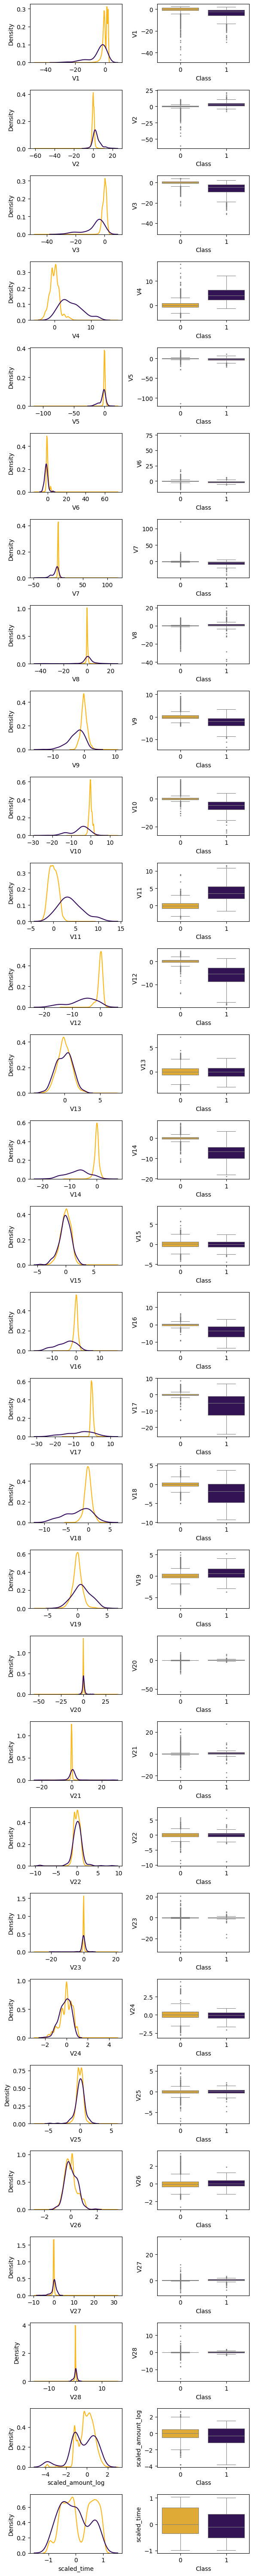

In [12]:
columns = data.columns
columns = columns.drop('Class')

num_cols = 2
num_rows = math.ceil(len(columns))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 2*num_rows))

for i in range(len(columns)):
    sns.kdeplot(data_val_A, x = columns[i], ax = axes[i, 0], color = BinCol[0])
    sns.kdeplot(data_val_F, x = columns[i], ax = axes[i, 0], color = BinCol[1])
    sns.boxplot(data=data_val, x='Class', y=columns[i], ax=axes[i, 1], hue = 'Class', palette = BinCol, linecolor="grey", linewidth=.75, 
                flierprops={'marker': '.', 'markersize': 2}, legend = None)

plt.tight_layout()
plt.show()

From the visualisation, the following features could be disregarded: **V5, V6, V8, V13, V15, V20, V21, V22, V23, V24, V25, V26, V27, V28**.

Features that will be used for training model:

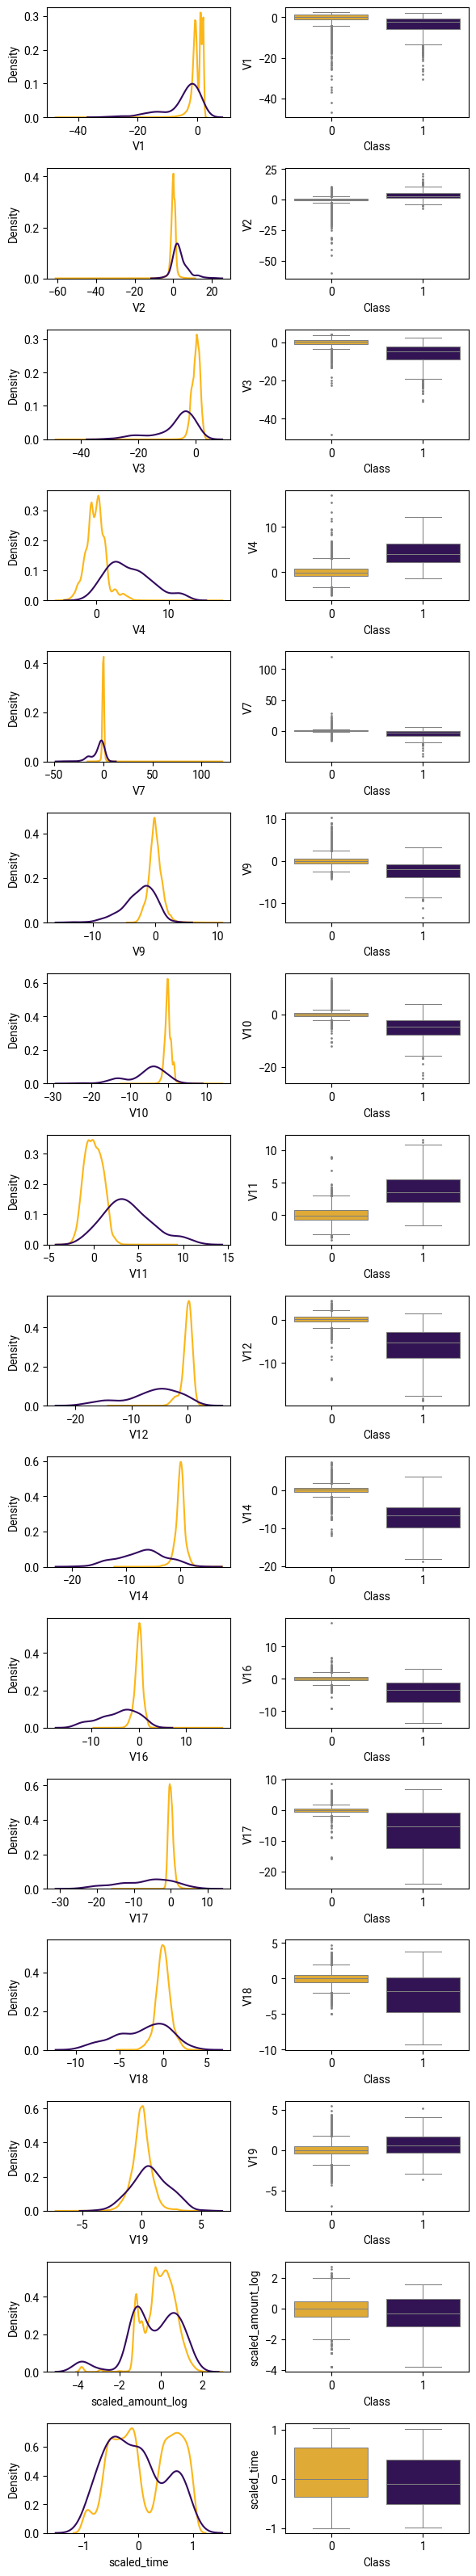

In [283]:
columns = data.columns
columns = columns.drop(['Class', 'V5', 'V6', 'V8', 'V13', 'V15', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'])

num_cols = 2
num_rows = math.ceil(len(columns))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 2*num_rows))

for i in range(len(columns)):
    sns.kdeplot(data_val_A, x = columns[i], ax = axes[i, 0], color = BinCol[0])
    sns.kdeplot(data_val_F, x = columns[i], ax = axes[i, 0], color = BinCol[1])
    sns.boxplot(data=data_val, x='Class', y=columns[i], ax=axes[i, 1], hue = 'Class', palette = BinCol, linecolor="grey", linewidth=.75, 
                flierprops={'marker': '.', 'markersize': 2}, legend = None)

plt.tight_layout()
plt.show()

Now, let's see the correlation between the features and the target. I will exclude the features having correlation values between (-0.1,0.1).

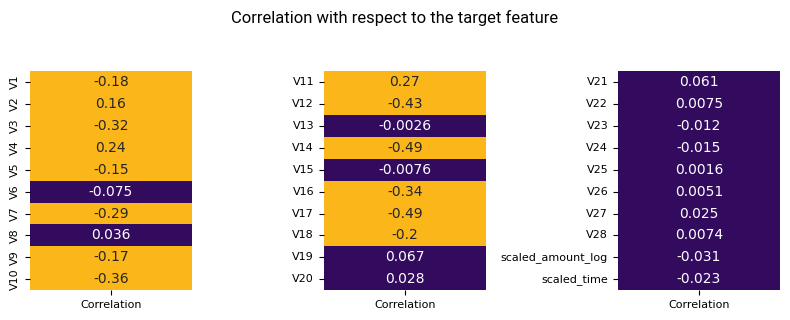

In [15]:
from matplotlib.colors import BoundaryNorm, ListedColormap

correlation_matrix = data_val.corr()
target_correlation = correlation_matrix['Class']
corr = target_correlation.to_frame()
corr.columns = ['Correlation']

pal_ = list(sns.color_palette(palette='inferno_r',
                              n_colors=5).as_hex())

my_colors = [pal_[0], pal_[4], pal_[0]]
my_cmap = ListedColormap(my_colors)
bounds = [-1, -0.1, 0.1, 1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

fig, axes  = plt.subplots(nrows = 1,ncols = 3, figsize = (8,3))

sns.heatmap(corr.iloc[:10,:],annot = True, cmap=my_cmap, norm=my_norm, cbar = False, ax = axes[0])
sns.heatmap(corr.iloc[10:20],annot = True, cmap=my_cmap, norm=my_norm, cbar = False, ax = axes[1])
sns.heatmap(corr.iloc[20:30],annot = True, cmap=my_cmap, norm=my_norm, cbar = False, ax = axes[2])

for ax in axes:
    ax.tick_params(labelsize=8)

plt.suptitle('Correlation with respect to the target feature', fontname='Roboto', fontsize=12, x=0.5, y=1.05)
fig.tight_layout()

plt.show()

From the correlation matrix, the following features could be disregarded: **V6, V8, V13, V15, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28**, largely agreeing with the visualisation estimation. To be on the safe side, I am dropping only the features that were deemed insignificant in both investigations. 

In [22]:
# Feature selection
cols = ['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'scaled_amount_log', 'scaled_time']


x_train_fs, x_val_fs, x_test_fs = x_train[cols], x_val[cols], x_test[cols]
x_train_fs.head()

V3        V4        V7       V10       V11       V12       V14  \
182516  0.199790 -2.381441 -0.178854  0.088878 -1.200063 -0.242341 -0.374740   
182203  0.628932 -2.809623  0.068811  0.954474  0.199316 -0.254582 -0.361780   
90215   0.613031  1.574648 -0.143708 -0.088812  0.535516  0.416082  0.208446   
189554 -0.844703 -0.426616  1.285337  0.037527  0.722999  0.110056  1.120216   
105175  0.744352  1.349040 -0.567454 -0.283213 -0.311956  1.722339 -0.771856   

             V16       V17       V18  scaled_amount_log  scaled_time  
182516  1.334245  0.032183 -1.312604           0.048733     0.478648  
182203 -0.459175 -0.086198  0.898900          -0.146004     0.477109  
90215   0.679186 -0.722012  1.012284           1.150647    -0.255748  
189554 -0.873169 -0.125060 -0.078014          -0.914002     0.514104  
105175 -0.645053  0.054145 -0.572917           0.218260    -0.179725

## Anomaly Detection Model 

The probability density function (pdf) of a univariate normal distribution with mean $( \mu )$ and standard deviation $( \sigma )$ is given by

$$
f(x; \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} \exp\left( -\frac{1}{2} \left(\frac{x - \mu}{\sigma}\right)^2 \right) 
$$
for $x$ in $\mathbb{R}$, where $\mu$ in $\mathbb{R}$ and $\sigma > 0$.

The probability density function (pdf) describes the likelihood of observing a particular value of the random variable.

In [17]:
def normal_density(x, mu, sigma):

    if sigma <= 0:
        raise ValueError("Standard deviation (sigma) must be a positive numeric value")
    
    f = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(- (1 / 2) * ((x - mu) / sigma)**2)
    return f

The following function calculates the product of these univariate normal densities. This can be interpreted as the joint probability density function (pdf) of several feature variables, each of which follows a univariate normal distribution and is statistically independent of the other features.

In [18]:
def normal_product(x_vec, mu_vec, sigma_vec):

    if min(sigma_vec) <= 0:
        raise ValueError("Standard deviation (sigma) must be a positive numeric value")

    if len(mu_vec) != len(x_vec):
        raise ValueError("Length of mean vector does not match length of input vector")

    if len(sigma_vec) != len(x_vec):
        raise ValueError("Length of standard deviation vector does not match length of input vector")

    f = 1
    
    for i in range(len(x_vec)):
        f = f * normal_density(x_vec[i], mu_vec[i], sigma_vec[i])
    return f

Now to train this model on the training set, I compute the vector of means and vector of standard deviations for the chosen features. 

In [19]:
mu_train, sigma_train = x_train_fs.mean().values, x_train_fs.std().values

def model_gaussian(X, epsilon):
    
    y = []
    for i in X.index:
        prob_density = normal_product(X.loc[i].tolist(), mu_train, sigma_train)

        if prob_density < epsilon:
            y.append(1)
        else: 
            y.append(0)
    return y

To run the model, we need to choose the threshold density value $\epsilon$, such that observations with a pdf value below the threshold are classified as anomalies (fraudulent), while those above are considered normal. I use the validation data and **F2** metric to optimise the threshold value.a.

In [ ]:
epsilon = np.arange(0.001, 0.051, 0.001)

y_pred = []
f2_eps = []

for i in epsilon:
    y = model_gaussian(x_val_fs, i**x_val_fs.shape[1])
    y_pred.append(y)
    precision, recall, f2 = metrics(y_val, y)
    f2_eps.append(f2)

plt.figure(figsize = (5, 3))
plt.plot(epsilon, f2_eps)
plt.title('F2-score vs epsilon', fontname='Roboto', fontsize=12)
plt.xlabel('F2', fontname='Roboto', fontsize=8)
plt.ylabel('epsilon', fontname='Roboto', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
index_opt = f2_eps.index(max(f2_eps))
eps_opt = epsilon[index_opt]
y_pred_opt = y_pred[index_opt]

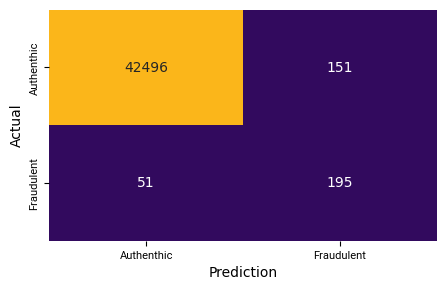

Precision:0.5635838150289018
Recall:0.7926829268292683
F2:0.7330827067669173


In [24]:
show_conf_mat(y_val, y_pred_opt)
precision, recall, f2 = metrics(y_val, y_pred_opt)
print('Precision:' + str(precision) + '\n' + 'Recall:' + str(recall) + '\n' + 'F2:' + str(f2))


## Evaluation on test dataset

Precision:0.5264550264550265
Recall:0.8089430894308943
F2:0.7305433186490455


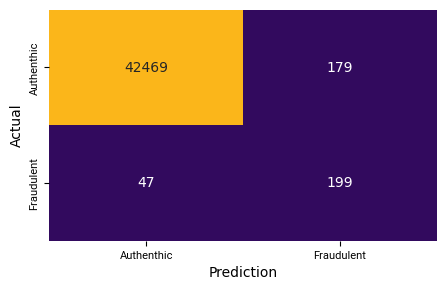

In [25]:
y_pred = model_gaussian(x_test_fs, eps_opt**x_test_fs.shape[1])

precision, recall, f2 = metrics(y_test, y_pred)
print('Precision:' + str(precision) + '\n' + 'Recall:' + str(recall) + '\n' + 'F2:' + str(f2))

show_conf_mat(y_test, y_pred)

The outcome is somewhat unsatisfactory, exhibiting a commendable recall of 0.81 but a subpar precision of 0.52.




# Machine Learning Algorithms

## Dataset split

For the next models, I am splitting the data again. This time, the training set will also include fraudulent transactions. I divide the data into authentic and fraudulent transactions first, split them separately in the same ratios, and then merge them into the training, validation and test sets. This way, I ensure that the fraudulent transactions are distributed equally. 

In [13]:
data_authentic, data_fraud = data[data.Class == 0], data[data.Class == 1]

# Function to split data and create DataFrame
def split_data(data, train_size, val_size):
    x, y = data.drop(columns=['Class']), data['Class']
    x_train, x_remaining, y_train, y_remaining = train_test_split(x, y, test_size=train_size, random_state=42, shuffle=True)
    x_val, x_test, y_val, y_test = train_test_split(x_remaining, y_remaining, test_size= val_size, random_state=42, shuffle=True)
    return pd.concat([x_train, y_train], axis=1), pd.concat([x_val, y_val], axis=1), pd.concat([x_test, y_test], axis=1)

# Split authentic data
data_atrain, data_aval, data_atest = split_data(data_authentic, train_size=0.30, val_size = 0.5)

# Split fraudulent data
data_ftrain, data_fval, data_ftest = split_data(data_fraud, train_size=0.30, val_size = 0.5)

# Concatenate authentic and fraudulent data for training, validation, and test sets
data_train = pd.concat([data_atrain, data_ftrain], axis=0).sample(frac=1, random_state=42)
data_val = pd.concat([data_aval, data_fval], axis=0).sample(frac=1, random_state=42)
data_test = pd.concat([data_atest, data_ftest], axis=0).sample(frac=1, random_state=42)

# Separate features and target for training, validation, and test sets
x_train, y_train = data_train.drop(columns=['Class']), data_train['Class']
x_val, y_val = data_val.drop(columns=['Class']), data_val['Class']
x_test, y_test = data_test.drop(columns=['Class']), data_test['Class']

## Default resampling

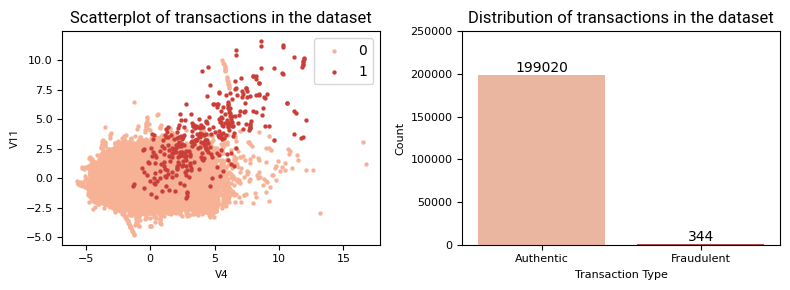

In [14]:
import imblearn
from collections import Counter
from numpy import where

pal_ = list(sns.color_palette(palette='coolwarm_r',
                              n_colors=15).as_hex())
BinCol = [pal_[0], pal_[4]]

def scatterplot_dist(data, x, y):
    
    # Convert to numpy arrays
    y_sct = np.array(y)
    x_sct = np.array(x['V4'])
    x0_sct = np.array(x['V11'])

    # Count occurrences of each class
    counter = Counter(y_sct)

    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    i=1

    #Plot scatter plot
    ax = axes[0]
    for label, _ in counter.items():
        #Find indices where y_sct == label
        row_ix = np.where(y_sct == label)[0]
     
        # Scatter plot for each class
        ax.scatter(x_sct[row_ix], x0_sct[row_ix], color = BinCol[i], label=str(label), marker='.', linewidths=0.1)
        i -= 1

    ax.set_xlabel('V4', fontname='Roboto', fontsize=8)
    ax.set_ylabel('V11', fontname='Roboto', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_title('Scatterplot of transactions in the dataset', fontname='Roboto', fontsize=12)
    ax.legend()

    # Plot bar plot
    auth = (data['Class'] == 0).sum()
    fraud = (data['Class'] == 1).sum()

    dist = pd.DataFrame({'Transaction Type': ['Authentic', 'Fraudulent'],
                     'Count': [auth, fraud]})

    ax = axes[1]
    sns.barplot(data=dist, hue='Transaction Type', palette=BinCol[::-1], x='Transaction Type', y='Count', ax=ax)
    ax.set_title('Distribution of transactions in the dataset', fontname='Roboto', fontsize=12)
    ax.set_xlabel('Transaction Type', fontsize=8)
    ax.set_ylabel('Count', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_ylim(0, 250000)

    for i, count in enumerate([auth, fraud]):
        ax.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

scatterplot_dist(data_train, x_train, y_train)

### SMOTE oversampling and random undersampling

Counter({0: 124387, 1: 49755})


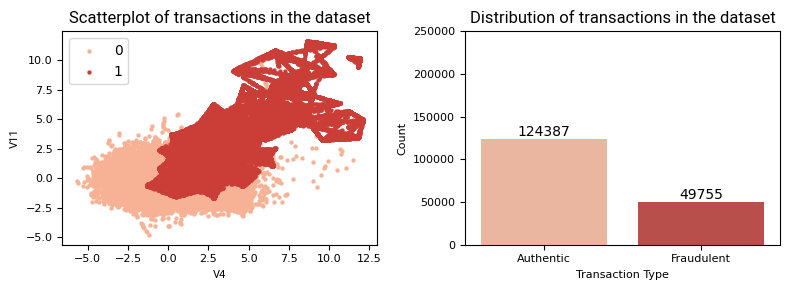

In [15]:
# Import necessary modules
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter

# Define SMOTE and RandomUnderSampler techniques with specified sampling strategies
over = SMOTE(sampling_strategy=0.25, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.4)

# Combine the sampling techniques into a pipeline
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Resample the data using the defined pipeline
x_resampled, y_resampled = pipeline.fit_resample(x_train, y_train)

# Concatenate resampled features and labels into a DataFrame
data_resampled = pd.concat([x_resampled, y_resampled], axis=1)

# Count the occurrences of each class after resampling
counter = Counter(y_resampled)
print(counter)

# Visualize the distribution of resampled data using scatterplot
scatterplot_dist(data_resampled, x_resampled, y_resampled)

## Feature selection

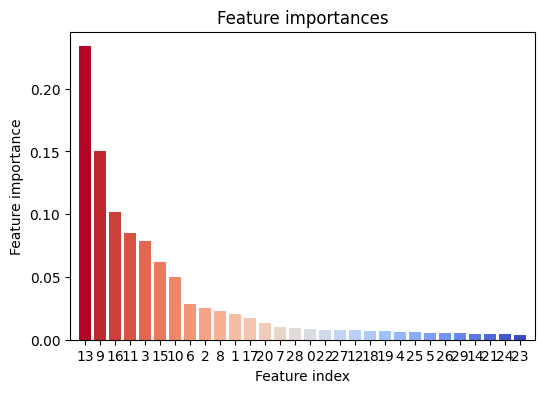

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()

# Train the model
rf_classifier.fit(x_resampled, y_resampled)

# Get feature importances
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

cols = x_resampled.columns[list(indices[:12])]

# Plot the feature importances using coolwarm palette
plt.figure(figsize=(6, 4))
plt.title("Feature importances")
plt.bar(range(x_resampled.shape[1]), importances[indices], color=plt.cm.coolwarm_r(np.linspace(0, 1, len(indices))), align="center")
plt.xticks(range(x_resampled.shape[1]), indices)
plt.xlim([-1, x_resampled.shape[1]])
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.show()

In [17]:
cols = x_resampled.columns[list(indices[:12])]
print(cols)

Index(['V14', 'V10', 'V17', 'V12', 'V4', 'V16', 'V11', 'V7', 'V3', 'V9', 'V2',
       'V18'],
      dtype='object')


## Training algorithms

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer

import collections
import time

X_train_resampled, Y_train_resampled = x_resampled[cols].values, y_resampled.values
X_val, Y_val = x_val[cols].values, y_val.values
X_test, Y_test = x_test[cols].values, y_test.values

classifiers = []

# Function to calculate precision, recall, F1, and F2 scores
def calculate_metrics(y_true, y_pred):
    confusion_mat = conf_mat(y_true, y_pred)  # Assuming conf_mat is defined elsewhere
    tn, fp, fn, tp = confusion_mat[0, 0], confusion_mat[0, 1], confusion_mat[1, 0], confusion_mat[1, 1]
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = (2 * precision * recall) / (precision + recall)
    f2 = (5 * precision * recall) / ((4 * precision) + recall)
    
    return precision, recall, f1, f2

# Function to create a scorer for a specific metric
def make_scorer_metric(metric_index):
    def scorer(y_true, y_pred):
        metrics_values = calculate_metrics(y_true, y_pred)
        return metrics_values[metric_index]
    return make_scorer(scorer, greater_is_better=True)

# Function for performing grid search with cross-validation
def paramSearch(model, space, scoring, cv, x_train, y_train):
    start_time = time.time()
    search = GridSearchCV(estimator=model, param_grid=space, scoring=scoring, n_jobs=-1, cv=cv, verbose = 10)
    result = search.fit(x_train, y_train)
    end_time = time.time()
    execution_time = time.time() - start_time

    print('Best Score:', result.best_score_)
    print('Best Hyperparameters:', result.best_params_)
    print('Time to optimise:', '{0:.2}'.format(execution_time))
    
    return result

In [ ]:
import warnings
from sklearn.exceptions import FitFailedWarning

# Define cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

# Define resampling techniques
over = SMOTE(sampling_strategy=0.25)
under = RandomUnderSampler(sampling_strategy=0.3)

# Define custom scoring functions
precision_score = make_scorer_metric(0)
recall_score = make_scorer_metric(1)
f1_score = make_scorer_metric(2)
f2_score = make_scorer_metric(3)

# Define the pipeline with resampling techniques
steps = [('over', over), ('under', under), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)

# Define search space for Logistic Regression
space_LR = {
    'model__solver': ['lbfgs', 'liblinear'],
    'model__penalty': ['balanced','l1', 'l2'],
    'model__C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
}

# Ignore FitFailedWarning
warnings.filterwarnings("ignore", category=FitFailedWarning)

# Ignore UserWarning related to non-finite test scores
warnings.filterwarnings("ignore", category=UserWarning)

# Perform grid search with resampling within each fold
resultLogReg = paramSearch(pipeline, space_LR, f2_score, cv, x_train[cols], y_train)

In [ ]:
#Repeat for SVC

# Define resampling techniques
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)


steps = [('over', over), ('under', under), ('model', SVC())]
pipeline = Pipeline(steps=steps)

space_SVC = {
    'model__kernel': ['rbf'],
    'model__gamma': [0.01, 0.1,0.001,0.0001],
    'model__C': [1e-2, 1e-1, 1]
}

resultSVC = paramSearch(pipeline, space_SVC, f2_score, cv, x_train[cols], y_train)

In [133]:
#Repeat for RandomForestClassifier

# Define cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42)

# Define resampling techniques
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.3)

steps = [('over', over), ('under', under), ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)

space_RF = { 
    'model__n_estimators': [100, 200],
    'model__max_depth' : [4, 5, 6, 7, 8],
    'model__criterion' :['gini', 'entropy']
}

resultRF = paramSearch(pipeline, space_RF, f2_score, cv, x_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Score: 0.8310259396277293
Best Hyperparameters: {'model__criterion': 'entropy', 'model__max_depth': 7, 'model__n_estimators': 200}


In [77]:
#Repeat for KNeighborsClassifier

# Define cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

# Define resampling techniques
over = SMOTE(sampling_strategy=0.25)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('over', over), ('under', under), ('model', KNeighborsClassifier())]
pipeline = Pipeline(steps=steps)

k_range = list(range(1, 10))
space_KN = {'model__n_neighbors': k_range}

resultKN = paramSearch(pipeline, space_KN, f2_score, cv, x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Score: 0.7627297702085819
Best Hyperparameters: {'model__n_neighbors': 1}


In [19]:
# Define classifiers with specified hyperparameters
classifiers = [
    LogisticRegression(C=1e-05, penalty='l2', solver='lbfgs'),
    SVC(C=0.1, gamma=0.0001, kernel='rbf'),
    RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=200),
    KNeighborsClassifier(n_neighbors=1)
]

# Initialize lists to store evaluation metrics and execution times
precision = []
recall = []
f1_scores = []
f2_scores = []
times = []

# Get names of the models
models = [classifier.__class__.__name__ for classifier in classifiers]

# Iterate over each classifier
for classifier in classifiers:
    start_time = time.time()
    
    # Train the classifier
    model = classifier.fit(X_train_resampled, Y_train_resampled)
    
    # Predict on validation data
    y_pred = model.predict(X_val)

    # Calculate precision, recall, F1-score, and F2-score
    p, r, f1, f2 = metrics(Y_val, y_pred)
    
    # Append evaluation metrics to lists
    precision.append('{0:.2}'.format(p))
    recall.append('{0:.2}'.format(r))
    f1_scores.append('{0:.2}'.format(f1))
    f2_scores.append('{0:.2}'.format(f2))
    
    # Calculate execution time
    execution_time = time.time() - start_time
    times.append('{0:.2f}'.format(execution_time))




C:\Users\defra\AppData\Local\Temp\ipykernel_16932\400635346.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_val = max_values[i]


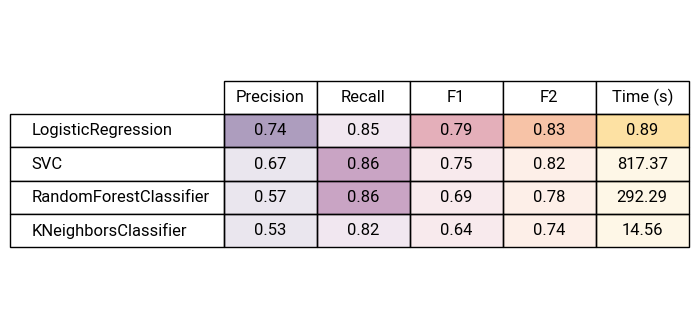

In [113]:
# Define data as a dictionary
data = {'Precision': precision,
        'Recall': recall,
        'F1': f1_scores,
        'F2': f2_scores,
        'Time (s)': times}

# Create DataFrame from the dictionary
df = pd.DataFrame(data, index=models)

# Define colors for the table cells
colors = sns.color_palette("inferno", n_colors=len(df.columns))

# Plot the evaluation metrics in a table
plt.figure(figsize=(6, 4))

# Create the table using pandas
table = plt.table(cellText=df.values,
                  rowLabels=df.index,
                  colLabels=df.columns,
                  loc='center',
                  cellLoc='center',
                  fontsize=12)

# Find the maximum value in each column and set transparency accordingly
max_values = df.max(axis=0)
for i in range(len(df.columns)-1):
    max_val = max_values[i]
    for j in range(len(df.index)):
        cell_val = df.iloc[j, i]
        alpha = 0.4 if cell_val == max_val else 0.1
        table.get_celld()[j + 1, i].set_facecolor((colors[i][0], colors[i][1], colors[i][2], alpha))

# Find the minimum value in the "Time" column and set transparency accordingly
min_time_value = df['Time (s)'].min()
for i in range(len(df.columns)-1,len(df.columns)):
    for j in range(len(df.index)):
        cell_val = df.iloc[j, i]
        alpha = 0.4 if df.columns[i] == 'Time (s)' and cell_val == min_time_value else 0.1
        table.get_celld()[j + 1, i].set_facecolor((colors[i][0], colors[i][1], colors[i][2], alpha))

# Hide axes
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

# Adjust cell padding and font size
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)  # Increase cell size

plt.rcParams['font.family'] = 'Roboto'

# Show the table plot
plt.show()

SVC and Random Forest yield the best recall, from which SVC has higher precision leading to decent F1-score. However, Logistic Regression provides a good recall and a precision, while being the fastest method, potentially being the most effective in our application. 

I am also trying out method from the research paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10535547/

In [60]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression

paper_KNN = KNeighborsClassifier(algorithm = 'auto', leaf_size = 30, metric = 'minkowski', metric_params = None, n_jobs = -1, n_neighbors = 5,
                                 p = 2, weights = 'uniform')
paper_LDA = LinearDiscriminantAnalysis(solver='svd', shrinkage=None, priors=None, n_components=None, store_covariance=False, tol=0.0001, 
                                       covariance_estimator=None)
paper_LR = LinearRegression()

In [63]:
# Train the model
modelKNN = paper_KNN.fit(X_train_resampled, y_resampled)
y_predKNN = modelKNN.predict(X_val)

modelLDA = paper_LDA.fit(X_train_resampled, y_resampled)
y_predLDA = modelKNN.predict(X_val)

modelLR = paper_LR.fit(X_train_resampled, y_resampled)
y_predLR = modelKNN.predict(X_val)

mvLR = np.average(y_predLR)

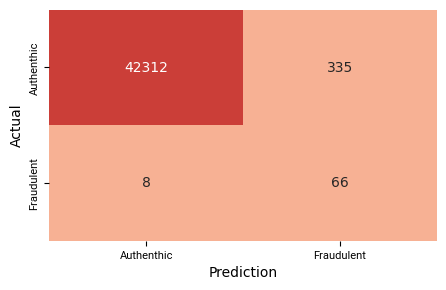

In [68]:
def custom_predict(pKNN, pLDA, pLR, mvLR):
    pOR = [] 
    
    for i in range(len(pKNN)):

        if pKNN[i] == 0 or pLDA[i] == 0:
            if pLR[i] < mvLR:
                pOR.append(0)
            else:
                pOR.append(1)
       
        elif pKNN[i] == 1 or pLDA[i] == 1:
            if pLR[i] > mvLR:
                pOR.append(1)
            else:
                pOR.append(0)
        else:
            pOR.append('error')
    
    return pOR

y_pred = custom_predict(y_predKNN, y_predLDA, y_predLR, mvLR)
show_conf_mat(Y_val, y_pred)
p, r, f1 , f2 = metrics(Y_val, y_pred)
print('Recall:' + str(r) + '<br>' +
      'Precision:' + str(p) + '<br>' +
      'F1 score:' + str(f1) + '<br>' +
      'F2 score:' + str(f2) + '<br>')

This method yields a very high recall, but the precision is notably low. While prioritizing recall aligns with our business objectives, flagging too many authentic transactions as fraudulent and halting them in real-time could lead to diminished customer satisfaction. Thus, despite its strong recall performance, this model is suboptimal for our purposes.




## Test Data

I am using the best model, SVC, for the test data. 

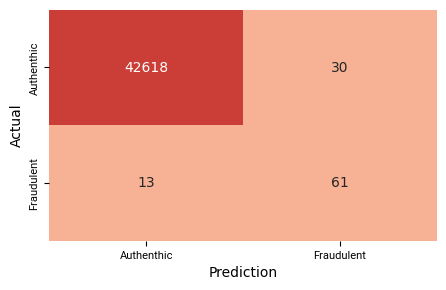

Recall:0.82
Precision:0.67
F1 score:0.74
F2 score:0.79


In [16]:
model = SVC(C = 0.1, gamma =0.0001, kernel = 'rbf').fit(X_train_resampled, Y_train_resampled)
y_pred = model.predict(X_test)
show_conf_mat(Y_test, y_pred)

p, r, f1 , f2 = metrics(Y_test, y_pred)
print('Recall:' + '{0:.2}'.format(r) + '\n' +
      'Precision:' + '{0:.2}'.format(p) + '\n' +
      'F1 score:' + '{0:.2}'.format(f1) + '\n' +
      'F2 score:' + '{0:.2}'.format(f2) )

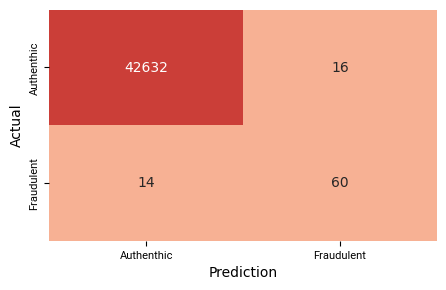

Recall:0.81
Precision:0.79
F1 score:0.8
F2 score:0.81


In [15]:
model = LogisticRegression(C = 1e-05, penalty = 'l2', solver= 'lbfgs').fit(X_train_resampled, Y_train_resampled)
y_pred = model.predict(X_test)
show_conf_mat(Y_test, y_pred)

p, r, f1 , f2 = metrics(Y_test, y_pred)
print('Recall:' + '{0:.2}'.format(r) + '\n' +
      'Precision:' + '{0:.2}'.format(p) + '\n' +
      'F1 score:' + '{0:.2}'.format(f1) + '\n' +
      'F2 score:' + '{0:.2}'.format(f2) )

## Models for Deployment

In [16]:
import pickle

LogReg_Deploy = LogisticRegression(C = 1e-05, penalty = 'l2', solver= 'lbfgs').fit(X_train_resampled, Y_train_resampled)
logistic_regression = pickle.dump(LogReg_Deploy, open('logreg_model', 'wb'))

SVC_Deploy = SVC(C = 0.1, gamma =0.0001, kernel = 'rbf').fit(X_train_resampled, Y_train_resampled)
svc = pickle.dump(SVC_Deploy, open('svc_model', 'wb'))